# ARIMA and SARIMAX

ARIMA (AutoRegressive Integrated Moving Average) and SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors) are prominent and widely used statistical forecasting models. While ARIMA models are more widely known, SARIMAX models extend the ARIMA framework by seamlessly integrating seasonal patterns and exogenous variables.

In the ARIMA-SARIMAX model notation, the parameters $p$, $d$, and $q$ represent the autoregressive, differencing, and moving-average components, respectively. $P$, $D$, and $Q$ denote the same components for the seasonal part of the model, with $m$ representing the number of periods in each season.

+ $p$ is the order (number of time lags) of the autoregressive part of the model.

+ $d$ is the degree of differencing (the number of times that past values have been subtracted from the data).

+ $q$ is the order of the moving average part of the model.

+ $P$ is the order (number of time lags) of the seasonal part of the model.

+ $D$ is the degree of differencing (the number of times the data have had past values subtracted) of the seasonal part of the model.

+ $Q$ is the order of the moving average of the seasonal part of the model.

+ $m$ refers to the number of periods in each season.

When the terms $P$, $D$, $Q$, and $m$ are zero and no exogenous variables are included in the model, the SARIMAX model is equivalent to an ARIMA.

When two out of the three terms are zero, the model can be referred to based on the non-zero parameter, dropping "AR", "I" or "MA" from the acronym describing the model. For example, $ARIMA(1,0,0)$ is $AR(1)$, $ARIMA(0,1,0)$ is $I(1)$, and $ARIMA(0,0,1)$ is $MA(1)$.

<font size="6">ARIMA implementations</font>

Several Python libraries implement ARIMA-SARIMAX models. Three of them are:

+ [statsmodels](https://www.statsmodels.org/stable/index.html): this is one of the most complete libraries for statistical modeling. While the functional paradigm may be intuitive for those coming from the R environment, those accustomed to the object-oriented API of scikit-learn may need a short period of adaptation.

+ [pmdarima](http://alkaline-ml.com/pmdarima/): This is a wrapper for `statsmodels SARIMAX`. Its distinguishing feature is its seamless integration with the scikit-learn API, allowing users familiar with scikit-learn's conventions to seamlessly dive into time series modeling.

+ [skforecast](https://skforecast.org/latest/index.html): a novel wrapper for `statsmodels SARIMAX` that also follows the scikit-learn API. This implementation is very similar to that of pmdarima, but has been streamlined to include only the essential elements for skforecast, resulting in significant speed improvements.

<font size="6">ForecasterSarimax</font>

The `ForecasterSarimax` class allows training and validation of ARIMA and SARIMAX models using the skforecast API. `ForecasterSarimax` is compatible with two ARIMA-SARIMAX implementations:

+ `ARIMA` from [pmdarima](http://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ARIMA.html#pmdarima.arima.ARIMA): a wrapper for [statsmodels SARIMAX](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) that follows the scikit-learn API.

+ `Sarimax` from [skforecast](https://skforecast.org/latest/api/sarimax): a novel wrapper for [statsmodels SARIMAX](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) that also follows the sklearn API. This implementation is very similar to pmdarima, but has been streamlined to include only the essential elements for skforecast, resulting in significant speed improvements.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

To learn more about modeling time series with ARIMA models, visit our example: <a href="https://www.cienciadedatos.net/documentos/py51-arima-sarimax-models-python.html">ARIMA and SARIMAX models with Python</a>.

</div>

## Libraries

In [1]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from skforecast.datasets import fetch_dataset
from pmdarima import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

## Data

In [2]:
# Download data
# ==============================================================================
data = fetch_dataset(name="h2o_exog")
data.index.name = 'datetime'

h2o_exog
--------
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008. Two additional variables (exog_1, exog_2) are
simulated.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice (3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,
https://github.com/robjhyndman/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (195, 3)


Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


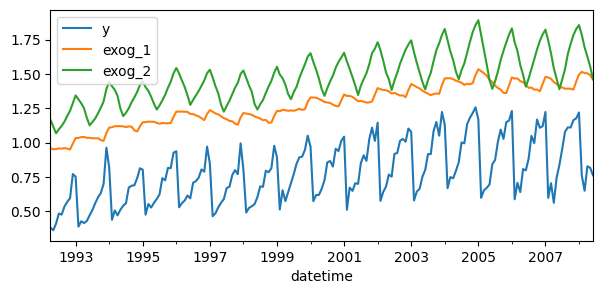

In [3]:
# Train-test dates
# ==============================================================================
end_train = '2005-06-01 23:59:59'
print(f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  (n={len(data.loc[:end_train])})")
print(f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  (n={len(data.loc[end_train:])})")
data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data.plot(ax=ax)
ax.legend();

## Statsmodels, pmdarima and skforecast

The following section focus on how to train an ARIMA model and forecast future values with each of the three libraries.

<font size="5">**statsmodels**</font>

In [4]:
# ARIMA model with statsmodels.Sarimax
# ==============================================================================
arima = SARIMAX(endog = data_train['y'], order = (1, 1, 1))
arima_res = arima.fit(disp=0)
arima_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  159
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  89.934
Date:                Mon, 29 Jul 2024   AIC                           -173.869
Time:                        17:39:12   BIC                           -164.681
Sample:                    04-01-1992   HQIC                          -170.137
                         - 06-01-2005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6316      0.143      4.420      0.000       0.352       0.912
ma.L1         -0.9535      0.054    -17.817      0.000      -1.058      -0.849
sigma2         0.0186      0.002      8.619      0.000       0.014       0.023
===================================================================================
Ljung-Box (L1) (Q):                   0.75   Jarque-Bera (JB):               167.05
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               2.13   Skew:                            -1.66
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [5]:
# Prediction
# ==============================================================================
predictions = arima_res.get_forecast(steps=12)
predictions.predicted_mean.head(4)

2005-07-01    0.859452
2005-08-01    0.870310
2005-09-01    0.877167
2005-10-01    0.881499
Freq: MS, Name: predicted_mean, dtype: float64

<font size="5">**pmdarima**</font>

In [6]:
# ARIMA model with pmdarima.ARIMA
# ==============================================================================
arima = ARIMA(order=(1, 1, 1), suppress_warnings=True)
arima.fit(y=data_train['y'])
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  159
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  93.643
Date:                Mon, 29 Jul 2024   AIC                           -179.286
Time:                        17:39:12   BIC                           -167.036
Sample:                    04-01-1992   HQIC                          -174.311
                         - 06-01-2005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0011      0.000      2.188      0.029       0.000       0.002
ar.L1          0.6023      0.108      5.584      0.000       0.391       0.814
ma.L1         -0.9995      2.322     -0.431      0.667      -5.550       3.551
sigma2         0.0175      0.041      0.432      0.666      -0.062       0.097
===================================================================================
Ljung-Box (L1) (Q):                   1.57   Jarque-Bera (JB):               130.09
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):               2.19   Skew:                            -1.49
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [7]:
# Prediction
# ==============================================================================
predictions = arima.predict(n_periods=12)
predictions.head(4)

2005-07-01    0.891939
2005-08-01    0.922945
2005-09-01    0.942706
2005-10-01    0.955694
Freq: MS, dtype: float64

<font size="5">**skforecast**</font>

In [8]:
# ARIMA model with skforecast.Sarimax
# ==============================================================================
arima = Sarimax(order=(1, 1, 1))
arima.fit(y=data_train['y'])
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  159
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  89.934
Date:                Mon, 29 Jul 2024   AIC                           -173.869
Time:                        17:39:12   BIC                           -164.681
Sample:                    04-01-1992   HQIC                          -170.137
                         - 06-01-2005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6316      0.143      4.420      0.000       0.352       0.912
ma.L1         -0.9535      0.054    -17.817      0.000      -1.058      -0.849
sigma2         0.0186      0.002      8.619      0.000       0.014       0.023
===================================================================================
Ljung-Box (L1) (Q):                   0.75   Jarque-Bera (JB):               167.05
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               2.13   Skew:                            -1.66
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
# Prediction
# ==============================================================================
predictions = arima.predict(steps=12)
predictions.head(4)

,pred
2005-07-01,0.859452
2005-08-01,0.870310
2005-09-01,0.877167
2005-10-01,0.881499


## ForecasterSarimax

The previous section introduced the construction of ARIMA-SARIMAX models using three different implementations. In order to seamlessly integrate these models with the various functionalities provided by skforecast, the next step is to encapsulate these models within a `ForecasterSarimax` object. This encapsulation harmonizes the intricacies of the model and allows for the coherent use of skforecast's extensive capabilities.

The following code is done using the skforecast `Sarimax` model, but the same code can be applied to the pmdarima `ARIMA` model.

## Training

In [10]:
# Create and fit ForecasterSarimax
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(12, 1, 1), seasonal_order=(0, 0, 0, 0), maxiter=200),
             )

forecaster.fit(y=data_train['y'], suppress_warnings=True)
forecaster

ForecasterSarimax 
Regressor: Sarimax(12,1,1)(0,0,0)[0] 
Regressor parameters: {'concentrate_scale': False, 'dates': None, 'disp': False, 'enforce_invertibility': True, 'enforce_stationarity': True, 'freq': None, 'hamilton_representation': False, 'maxiter': 200, 'measurement_error': False, 'method': 'lbfgs', 'missing': 'none', 'mle_regression': True, 'order': (12, 1, 1), 'seasonal_order': (0, 0, 0, 0), 'simple_differencing': False, 'sm_fit_kwargs': {}, 'sm_init_kwargs': {}, 'sm_predict_kwargs': {}, 'start_params': None, 'time_varying_regression': False, 'trend': None, 'trend_offset': 1, 'use_exact_diffuse': False, 'validate_specification': True} 
fit_kwargs: {} 
Window size: 1 
Transformer for y: None 
Transformer for exog: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Creation date:

## Prediction

In [11]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=36)
predictions.head(3)

2005-07-01    0.957727
2005-08-01    0.960103
2005-09-01    1.108399
Freq: MS, Name: pred, dtype: float64

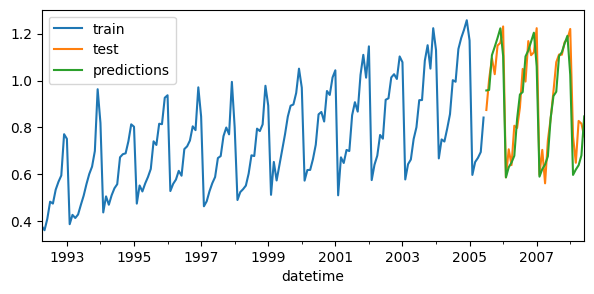

In [12]:
# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [13]:
# Prediction error
# ==============================================================================
error_mse = mean_absolute_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.07123026078782618


## Interval prediction

Either `alpha` or `interval` can be used to indicate the confidence of the estimated prediction interval.

In [14]:
# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(steps=36, alpha=0.05)
predictions.head(3)

,pred,lower_bound,upper_bound
2005-07-01,0.957727,0.857672,1.057781
2005-08-01,0.960103,0.853857,1.066350
2005-09-01,1.108399,0.997995,1.218803


## Exogenous variables

The addition of exogenous variables is done using the `exog` argument. The only requirement for including an exogenous variable is the need to know the value of the variable also during the forecast period.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

To learn more about exogenous variables and how to correctly manage them with skforecast visit: <a href="https://skforecast.org/latest/user_guides/exogenous-variables">Exogenous variables (features) user guide</a>.

</div>

In [15]:
# Create and fit ForecasterSarimax with exogenous variables
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(12, 1, 1), seasonal_order=(0, 0, 0, 0), maxiter=200),
             )

forecaster.fit(
    y                 = data_train['y'], 
    exog              = data_train[['exog_1', 'exog_2']],
    suppress_warnings = True
)

# Predict with exog
# ==============================================================================
predictions = forecaster.predict(
                  steps = 36,
                  exog  = data_test[['exog_1', 'exog_2']]
              )
predictions.head(3)

2005-07-01    0.904069
2005-08-01    0.931670
2005-09-01    1.089182
Freq: MS, Name: pred, dtype: float64

## Using an already trained ARIMA

Forecasting with an ARIMA model becomes challenging when the forecast horizon data does not immediately follow the last observed value during the training phase. This complexity is due to the moving average (MA) component, which relies on past forecast errors as predictors. Thus, to predict at time 't', the error of the 't-1' prediction becomes a necessity. In situations where this prediction isn't available, the corresponding error remains unavailable.

For this reason, in most cases, ARIMA models are retrained each time predictions need to be made. Despite considerable efforts and advances to speed up the training process for these models, it is not always feasible to retrain the model between predictions, either due to time constraints or insufficient computational resources for repeated access to historical data. An intermediate approach is to feed the model with data from the last training observation to the start of the prediction phase. This technique enables the estimation of intermediate predictions and, as a result, the necessary errors.

For example, imagine a situation where a model was trained 20 days ago with daily data from the past three years. When generating new predictions, only the 20 most recent values would be needed, rather than the complete historical dataset (365 * 3 + 20).

Integrating new data into the model can be complex, but the `ForecasterSarimax` class simplifies this considerably by automating the process through the `last_window` argument in its `predict` method.

Train dates       : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Last window dates : 2005-07-01 00:00:00 --- 2007-06-01 00:00:00  (n=24)
Test dates        : 2007-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=12)


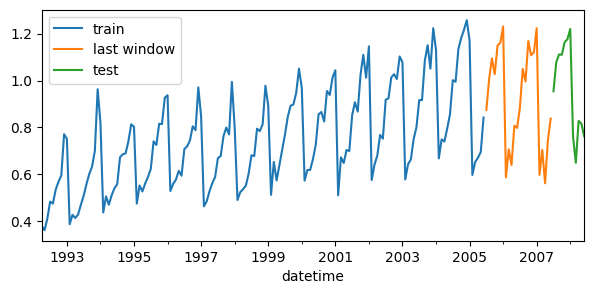

In [16]:
# Split data Train - Last window - Test
# ==============================================================================
end_train = '2005-06-01 23:59:59'
end_last_window = '2007-06-01 23:59:59'

print(
    f"Train dates       : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Last window dates : {data.loc[end_train:].index.min()} --- {data.loc[:end_last_window].index.max()}  "
    f"(n={len(data.loc[end_train:end_last_window])})"
)
print(
    f"Test dates        : {data.loc[end_last_window:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_last_window:])})"
)
data_train       = data.loc[:end_train]
data_last_window = data.loc[end_train:end_last_window]
data_test        = data.loc[end_last_window:]

# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_last_window['y'].plot(ax=ax, label='last window')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

Since exogenous variables have been included in the Forecaster tuning, it is necessary to pass both past values and their future values to the `predict` method using the `last_window_exog` and `exog` parameters when making predictions.

In [17]:
# Create and fit ForecasterSarimax with exogenous variables
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(12, 1, 1), seasonal_order=(0, 0, 0, 0), maxiter=200),
             )

forecaster.fit(
    y                 = data_train['y'], 
    exog              = data_train[['exog_1', 'exog_2']],
    suppress_warnings = True
)

# Predict with exog and last window
# ==============================================================================
predictions = forecaster.predict(
                  steps            = 12,
                  exog             = data_test[['exog_1', 'exog_2']],
                  last_window      = data_last_window['y'],
                  last_window_exog = data_last_window[['exog_1', 'exog_2']]
              )
predictions.head(3)

2007-07-01    0.883806
2007-08-01    1.041050
2007-09-01    1.071687
Freq: MS, Name: pred, dtype: float64

In [18]:
# Prediction error
# ==============================================================================
error_mse = mean_absolute_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.06280550767395036


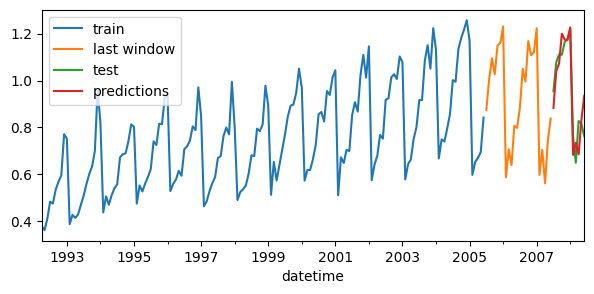

In [19]:
# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_last_window['y'].plot(ax=ax, label='last window')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

## Feature importances

Returns the parameters of the model.

In [20]:
# Feature importances
# ==============================================================================
forecaster.get_feature_importances()

,feature,importance
1,exog_2,1.523893
13,ar.L12,0.674807
15,sigma2,0.001585
12,ar.L11,-0.148613
2,ar.L1,-0.159481
6,ar.L5,-0.188342
4,ar.L3,-0.190626
7,ar.L6,-0.207007
10,ar.L9,-0.208029
9,ar.L8,-0.210240


## Backtesting

SARIMAX models can be evaluated using any of the [backtesting strategies](https://skforecast.org/latest/introduction-forecasting/introduction-forecasting.html#backtesting-forecasting-models) implemented in skforecast.

In [21]:
# Backtest forecaster
# ======================================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(12, 1, 1), seasonal_order=(0, 0, 0, 0), maxiter=200),
             )

metric, predictions = backtesting_sarimax(
                          forecaster            = forecaster,
                          y                     = data['y'],
                          exog                  = data[['exog_1', 'exog_2']],
                          initial_train_size    = len(data_train),
                          fixed_train_size      = False,
                          steps                 = 12,
                          metric                = 'mean_absolute_error',
                          refit                 = True,
                          n_jobs                = 'auto',
                          suppress_warnings_fit = True,
                          verbose               = True,
                          show_progress         = True
                      )

metric

Information of backtesting process
----------------------------------
Number of observations used for initial training: 159
Number of observations used for backtesting: 36
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 12
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00  (n=159)
    Validation: 2005-07-01 00:00:00 -- 2006-06-01 00:00:00  (n=12)
Fold: 1
    Training:   1992-04-01 00:00:00 -- 2006-06-01 00:00:00  (n=171)
    Validation: 2006-07-01 00:00:00 -- 2007-06-01 00:00:00  (n=12)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2007-06-01 00:00:00  (n=183)
    Validation: 2007-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=12)



  0%|          | 0/3 [00:00<?, ?it/s]

,mean_absolute_error
0,0.056369


In [22]:
# Backtest predictions
# ======================================================================================
predictions.head(4)

,pred
2005-07-01,0.904069
2005-08-01,0.931670
2005-09-01,1.089182
2005-10-01,1.113034


## Model tunning


To find the optimal hyperparameters for the SARIMAX model, the use of strategic search methods is essential. Among these methods, two widely used approaches are:

+ **Statistical Criteria**: Information criterion metrics, such as Akaike's Information Criterion (AIC) or Bayesian Information Criterion (BIC), use different penalties on the maximum likelihood (log-likelihood) estimate of the model as a measure of fit. The advantage of using such criteria is that they are computed only on the training data, eliminating the need for predictions on new data. As a result, the optimization process is greatly accelerated. The well-known Auto Arima algorithm uses this approach.

+ **Validation Techniques**: The use of validation techniques, especially [backtesting](https://skforecast.org/latest/user_guides/hyperparameter-tuning-and-lags-selection.html), is another effective strategy. Backtesting involves evaluating the performance of the model using historical data to simulate real-world conditions. This helps to validate the effectiveness of the hyperparameters under different scenarios, providing a practical assessment of their viability.


In the first approach, calculations are based solely on training data, eliminating the need for predictions on new data. This makes the optimization process very fast. However, it is important to note that information criteria metrics only measure the relative quality of models. This means that all tested models could still be poor fits. Therefore, the final selected model must undergo a backtesting phase. This phase calculates a metric (such as MAE, MSE, MAPE, etc.) that validates its performance on a meaningful scale.

On the other hand, the second approach - validation techniques - tends to be more time-consuming, since the model must be trained and then evaluated on new data. However, the results generated are often more robust, and the metrics derived can provide deeper insights.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

In summary, while the statistical criteria approach offers speed and efficiency, validation techniques provide a more comprehensive and insightful evaluation, albeit at a slower pace due to their reliance on new data for testing. Fortunately, for sufficiently large data sets, they all lead to the same model.

</div>

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

When evaluating ARIMA-SARIMAX models, it is important to note that AIC assumes that all models are trained on the same data. Thus, using AIC to decide between different orders of differencing is technically invalid, since one data point is lost with each order of differencing. Therefore, the Auto Arima algorithm uses a unit root test to select the order of differencing, and only uses the AIC to select the order of the AR and MA components.

</div>

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

For a detailed explanation of Akaike's Information Criterion (AIC) see <a href="https://robjhyndman.com/hyndsight/aic/">Rob J Hyndman's blog</a> and <a href="https://sites.warnercnr.colostate.edu/anderson/wp-content/uploads/sites/26/2016/11/AIC-Myths-and-Misunderstandings.pdf">AIC Myths and Misunderstandings by Anderson and Burnham</a>.

</div>

Train dates      : 1992-04-01 00:00:00 --- 2001-01-01 00:00:00  (n=106)
Validation dates : 2001-02-01 00:00:00 --- 2006-01-01 00:00:00  (n=60)
Test dates       : 2006-02-01 00:00:00 --- 2008-06-01 00:00:00  (n=29)


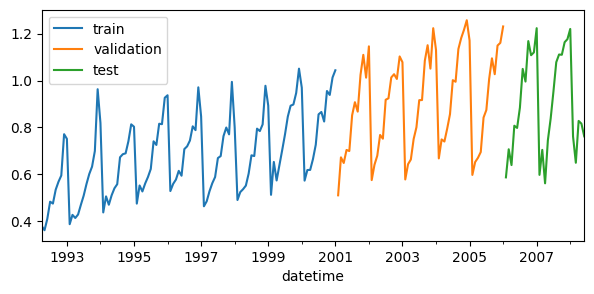

In [23]:
# Train-validation-test data
# ======================================================================================
end_train = '2001-01-01 23:59:00'
end_val = '2006-01-01 23:59:00'

print(f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}  (n={len(data.loc[:end_train])})")
print(f"Validation dates : {data.loc[end_train:].index.min()} --- {data.loc[:end_val].index.max()}  (n={len(data.loc[end_train:end_val])})")
print(f"Test dates       : {data.loc[end_val:].index.min()} --- {data.index.max()}  (n={len(data.loc[end_val:])})")

# Plot
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data.loc[:end_train, 'y'].plot(ax=ax, label='train')
data.loc[end_train:end_val, 'y'].plot(ax=ax, label='validation')
data.loc[end_val:, 'y'].plot(ax=ax, label='test')
ax.legend();

### Grid search with backtesting

In [24]:
# Grid search hyperparameter
# ======================================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(12, 1, 1), maxiter=200),
             )

param_grid = {
    'order': [(12, 0, 0), (12, 1, 0), (12, 1, 1)],
    'trend': [None, 'n', 'c']
}

results_grid = grid_search_sarimax(
                   forecaster            = forecaster,
                   y                     = data.loc[:end_val, 'y'],
                   param_grid            = param_grid,
                   steps                 = 12,
                   refit                 = False,
                   metric                = 'mean_absolute_error',
                   initial_train_size    = len(data_train),
                   fixed_train_size      = False,
                   return_best           = True,
                   n_jobs                = 'auto',
                   suppress_warnings_fit = True,
                   verbose               = False,
                   show_progress         = True
               )

results_grid.head(5)

Number of models compared: 9.


params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found parameters, and the whole data set: 
  Parameters: {'order': (12, 1, 1), 'trend': None}
  Backtesting metric: 0.06859275472246462



,params,mean_absolute_error,order,trend
6,"{'order': (12, 1, 1), 'trend': None}",0.068593,"(12, 1, 1)",None
7,"{'order': (12, 1, 1), 'trend': 'n'}",0.068593,"(12, 1, 1)",n
2,"{'order': (12, 0, 0), 'trend': 'c'}",0.077191,"(12, 0, 0)",c
0,"{'order': (12, 0, 0), 'trend': None}",0.077694,"(12, 0, 0)",None
1,"{'order': (12, 0, 0), 'trend': 'n'}",0.077694,"(12, 0, 0)",n


Since `return_best = True`, the Forecaster object is updated with the most optimal configuration found and trained with the entire dataset. This means that the grid search will yield the lowest error model with the best hyperparameters that lead to the highest performance metric. This last model can subsequently be utilized for forecasts on new data.

In [25]:
forecaster

ForecasterSarimax 
Regressor: Sarimax(12,1,1)(0,0,0)[0] 
Regressor parameters: {'concentrate_scale': False, 'dates': None, 'disp': False, 'enforce_invertibility': True, 'enforce_stationarity': True, 'freq': None, 'hamilton_representation': False, 'maxiter': 200, 'measurement_error': False, 'method': 'lbfgs', 'missing': 'none', 'mle_regression': True, 'order': (12, 1, 1), 'seasonal_order': (0, 0, 0, 0), 'simple_differencing': False, 'sm_fit_kwargs': {}, 'sm_init_kwargs': {}, 'sm_predict_kwargs': {}, 'start_params': None, 'time_varying_regression': False, 'trend': None, 'trend_offset': 1, 'use_exact_diffuse': False, 'validate_specification': True} 
fit_kwargs: {} 
Window size: 1 
Transformer for y: None 
Transformer for exog: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2006-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Creation date:

### Auto arima

In [26]:
# Auto arima: selection base on AIC
# ==============================================================================
model = auto_arima(
            y                 = data.loc[:end_val, 'y'],
            start_p           = 12,
            start_q           = 0,
            max_p             = 12,
            max_q             = 1,
            seasonal          = True,
            test              = 'adf',
            m                 = 12, # Seasonal period
            d                 = None, # The algorithm will determine 'd'
            D                 = None, # The algorithm will determine 'D'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )

Performing stepwise search to minimize aic
 ARIMA(11,1,0)(1,1,1)[12]             : AIC=-465.630, Time=3.32 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-383.254, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-439.401, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-463.505, Time=0.32 sec
 ARIMA(11,1,0)(0,1,1)[12]             : AIC=-467.479, Time=1.53 sec
 ARIMA(11,1,0)(0,1,0)[12]             : AIC=-439.864, Time=0.57 sec
 ARIMA(11,1,0)(0,1,2)[12]             : AIC=-465.752, Time=3.32 sec
 ARIMA(11,1,0)(1,1,0)[12]             : AIC=-450.415, Time=1.56 sec
 ARIMA(11,1,0)(1,1,2)[12]             : AIC=-464.761, Time=3.65 sec
 ARIMA(10,1,0)(0,1,1)[12]             : AIC=-466.868, Time=1.38 sec
 ARIMA(11,1,1)(0,1,1)[12]             : AIC=-464.317, Time=1.55 sec
 ARIMA(10,1,1)(0,1,1)[12]             : AIC=-464.448, Time=1.53 sec
 ARIMA(11,1,0)(0,1,1)[12] intercept   : AIC=-465.810, Time=1.47 sec

Best model:  ARIMA(11,1,0)(0,1,1)[12]          
Total fit time: 20.469 seco

## Prediction on training data (In-sample Predictions)

Predictions on the training data are crucial for evaluating the accuracy and effectiveness of the model. By comparing the predicted values wtih the actual observed values in the training dataset, you can assess how well the model has learned the underlying patterns and trends in the data. This comparison helps in understanding the model's performance and identify areas where it may need improvement or adjustment. In essence, they act as a mirror, reflecting how the model interprets and reconstructs the historical data on which it was trained.

The [predictions of the fitted values](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.fittedvalues.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.fittedvalues) are stored in the `fittedvalues` attribute of the `SARIMAXResults` object. This object is stored within the `sarimax_res` attribute of the [`skforecast.Sarimax` model](https://skforecast.org/latest/api/sarimax):

In [27]:
# Create and fit ForecasterSarimax (skforecast)
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(12, 1, 1), maxiter=200),
             )
forecaster.fit(y=data_train['y'], suppress_warnings=True)

# In-sample Predictions
# ==============================================================================
forecaster.regressor.sarimax_res.fittedvalues

datetime
1992-04-01    0.000000
1992-05-01    0.379808
1992-06-01    0.361444
1992-07-01    0.413136
1992-08-01    0.480509
                ...   
2005-02-01    0.739239
2005-03-01    0.750984
2005-04-01    0.716174
2005-05-01    0.749955
2005-06-01    0.817745
Freq: MS, Length: 159, dtype: float64

When using the `pmdarima.ARIMA` model, the statsmodels `SARIMAXResults` object is stored inside the `arima_res_` attribute:

In [28]:
# Create and fit ForecasterSarimax (pmdarima)
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=ARIMA(order=(12, 1, 1), maxiter=200),
             )
forecaster.fit(y=data_train['y'], suppress_warnings=True)

# In-sample Predictions
# ==============================================================================
forecaster.regressor.arima_res_.fittedvalues

datetime
1992-04-01    0.002790
1992-05-01    0.382598
1992-06-01    0.363529
1992-07-01    0.417322
1992-08-01    0.486638
                ...   
2005-02-01    0.740412
2005-03-01    0.755329
2005-04-01    0.724481
2005-05-01    0.762504
2005-06-01    0.832624
Freq: MS, Length: 159, dtype: float64